In [1]:
cd "/home/enesk/repos/spatial-prediction"

/home/enesk/repos/spatial-prediction


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
from data_set import Dataset
from predictor import Predictor, models
from predictor_utils import PiecewiseSchedule, OptimizerSpec
from utils import get_session, plot_grid, plot_confusion_matrix
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import reverb
import pandas as pd
from datetime import datetime
import random
from matplotlib import rc
import matplotlib
from active_sensing_environment import ExplorationEnvironment
from rl_env import RLEnv
import custom_py_driver
import json


import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential, q_network
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import categorical_q_network
from tf_agents.trajectories import TimeStep
from tf_agents.policies import policy_saver

2023-06-20 16:03:05.749820: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(os.environ['LD_LIBRARY_PATH'])
print(os.environ['XLA_FLAGS'])


/home/enesk/miniconda3/envs/triad4/lib/:/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorrt_libs/
--xla_gpu_cuda_data_dir=/usr/lib/cuda


In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,' # We don't need a GPU to test the model
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-06-20 16:03:08.044881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:08.051215: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:08.051522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
class TemperatureSchedule:
    def __init__(self):
        self.temp = 0.0
    def get_temp(self,):
        return self.temp

In [6]:
# Training parameters
all_params = {
"num_iterations" :  2000000, # @param {type:"integer"}
"n_step_update" :  5,
"initial_collect_steps" :  100000,  # 30000 @param {type:"integer"}
"collect_steps_per_iteration" :    1,# @param {type:"integer"}
"replay_buffer_max_length" :  4000000,  # @param {type:"integer"}
"batch_size" :  64, # @param {type:"integer"}
"learning_rate" :  5e-5,  # @param {type:"number"}
"log_interval" :  200,  # @param {type:"integer"}
"gamma" :  0.99,
"boltzmann_temperature" :  None, # temp_schedule.get_temp
"fc_layer_params" :  (512, 20),
"epsilon" :  0.03,
"model_restore_path" : None, 
#"conv_layer_params" : [(32,4,4), (64,4,4), (128,2,2)],
"conv_layer_params" : [(64,4,2), (128,4,2), (256,2,2)],
"target_update_tau" :  1,
"target_update_period" : 1000,
"num_eval_episodes" :  300,  # @param {type:"integer"}
"eval_interval" :  50000 , # @param {type:"integer"}
"single_env" :   False,
"use_sd" :  True,
"clairvoyante" :  False,
"num_atoms" : 70,  # @param {type:"integer"}
"use_categorical_dqn" : True,
"min_q_value" : 0,  # @param {type:"integer"}
"max_q_value" : 40, # @param {type:"integer"}
"use_imitation_learning" : False,
"use_pretrain_imitation_learning" : False,
"new_reward_function" : 2,
"step_size" : 4,
"random_init" : 0,
"n_agents" : 3,
"pred_session_name" : 'rand_walk_interpol_2_uav',
}

for key,val in all_params.items():
    exec(key + '=val')

In [7]:
# Setup environment 
env = RLEnv(model_path=pred_session_name, single_env = single_env, use_sd=use_sd, 
                clairvoyante = clairvoyante, use_imitation_learning=use_imitation_learning,
                    step_size = step_size, new_reward_function = new_reward_function, random_init=random_init,
                        n_uavs = n_agents)



There are 660 training grids.
There are 327 testing grids.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Unet Layers Shapes:
(None, 96, 96, 2)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 96, 96, 16]), TensorShape([None, 48, 48, 16]))


2023-06-20 16:03:13.604540: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:13.604893: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:13.605154: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 48, 48, 32]), TensorShape([None, 24, 24, 32]))
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
(TensorShape([None, 24, 24, 64]), TensorShape([None, 12, 12, 64]))
(TensorShape([None, 12, 12

2023-06-20 16:03:18.435042: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:18.435254: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-20 16:03:18.435388: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-20 16:03:18.435675: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:18.435885: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-20 16:03:19.460593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:19.460844: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-20 16:03:19.461148: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-20 16:03:19.461956: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:19.462181: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Linked TensorRT version: (8, 4, 3)
INFO:tensorflow:Loaded TensorRT version: (8, 6, 1)
INFO:tensorflow:Loaded TensorRT 8.6.1 and linked TensorFlow against TensorRT 8.4.3. This is supported because TensorRT minor/patch upgrades are backward compatible.


2023-06-20 16:03:23.099131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:23.099423: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-20 16:03:23.099728: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-20 16:03:23.100743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:23.101045: I tensorflow/compiler/xla/stream_executor/

INFO:tensorflow:Clearing prior device assignments in loaded saved model


2023-06-20 16:03:23.704334: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:23.704558: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2023-06-20 16:03:23.704661: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-06-20 16:03:23.704930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-20 16:03:23.705113: I tensorflow/compiler/xla/stream_executor/

BoundedArraySpec(shape=(24, 24, 4), dtype=dtype('float32'), name='observation', minimum=-3.4028234663852886e+38, maximum=3.4028234663852886e+38)


In [8]:
# Storage folder
rl_session_name = datetime.now().strftime("%Y-%m-%d--%H:%M:%S")
#rl_session_name = '2023-05-13--21:30:16'
base_dir = "/home/enesk/repos/spatial-prediction/models/RL"
train_log_dir = base_dir +'/' + rl_session_name
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
train_summary_writer.set_as_default()
rl_session_name

'2023-06-20--16:03:24'

In [9]:
# Store config
config_to_store = json.dumps(all_params)
with open(train_log_dir+'/config.json', 'w') as f:
    json.dump(config_to_store, f)

In [10]:
# Convert to TF environment
train_py_env = env
eval_py_env = env
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [11]:

def main():
    env.ee.policy = "random"
    env.ee.action_space.repeat_probability = 0.9
    all_rewards = []
    final_errors = []
    
    for _ in range(1):
        time_steps = train_py_env.reset()
        reward_in_episode = 0
        while not time_steps[0].is_last():
            time_steps = train_py_env.step(action=[1 for _ in time_steps])
            reward_in_episode += time_steps[0].reward
        all_rewards.append(reward_in_episode)
        final_errors.append(env.current_error)
    print("Reward per epsisode", np.mean(all_rewards))
    print("Average error", np.mean(final_errors))
    env.ee.policy = "rl"

%lprun -u 1e-3 -f train_py_env.ee.predict_ss main()


2023-06-20 16:03:26.230168: I tensorflow/compiler/tf2tensorrt/common/utils.cc:104] Linked TensorRT version: 8.4.3
2023-06-20 16:03:26.230278: I tensorflow/compiler/tf2tensorrt/common/utils.cc:106] Loaded TensorRT version: 8.6.1
2023-06-20 16:03:33.473177: I tensorflow/compiler/tf2tensorrt/convert/convert_nodes.cc:1330] [TF-TRT] Sparse compute capability: enabled.


Reward per epsisode 23.79741096496582
Average error 16.202589327937044


Timer unit: 0.001 s

Total time: 130.3 s
File: /home/enesk/repos/spatial-prediction/active_sensing_environment.py
Function: predict_ss at line 469

Line #      Hits         Time  Per Hit   % Time  Line Contents
   469                                           	def predict_ss(self, user_idx =0, no_full_covariance = False):
   470        52          0.8      0.0      0.0  		city_ob = self.building_grid
   471        52          0.8      0.0      0.0  		pwr_ob = self.ss_grids[user_idx]
   472        52          0.9      0.0      0.0  		indoor = self.building_grid > self.flying_altitude
   473                                           
   474                                           		# Get measured coords
   475        52         14.3      0.3      0.0  		measured_coords = self.get_measured_coords()
   476                                           
   477                                           		# UAV location grid for all UAVs
   478        52          0.9      0.0      0.0  		uav_lo

In [12]:
# Q-network 
if use_categorical_dqn:
    q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=num_atoms,
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)
else:
    print("Using standard DQN")
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        conv_layer_params=conv_layer_params,
        fc_layer_params=fc_layer_params)   


In [13]:
# DQN Agent
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0, dtype=tf.int64)

if use_categorical_dqn:
    agent = categorical_dqn_agent.CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        categorical_q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        min_q_value=min_q_value,
        debug_summaries=True,
        max_q_value=max_q_value,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)
else:
    print("Using standard DQN agent")
    agent = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        target_update_tau=target_update_tau,
        target_update_period=target_update_period,
        epsilon_greedy=epsilon,
        q_network=q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        boltzmann_temperature=boltzmann_temperature,
        gamma=gamma,
        debug_summaries=True,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

agent.initialize()

2023-06-20 16:05:36.811330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-06-20 16:05:37.469807: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [14]:
# # Define eval function
# def compute_avg_return(environment, py_environment, policy, num_episodes=10):

#   total_return = 0.0
#   episode_errors = []

#   for i in range(num_episodes):

#     time_step = environment.reset()
#     episode_return = 0.0
    

#     while not time_step.is_last():
#       action_step = policy.action(time_step)
#       time_step = environment.step(action_step.action)
#       episode_return += time_step.reward
#     total_return += episode_return
#     episode_errors.append(py_environment.current_error)

#   avg_return = total_return / num_episodes
#   return avg_return.numpy()[0], np.mean(episode_errors), episode_errors

# # New eval function
# # Define eval function
def compute_avg_return(environment, policy, n_agents, num_episodes, batched = True):

  total_return = 0.0
  episode_errors = []

  for i in range(num_episodes):
    # Note that there will be multiple timestep objects for multiple n_agents
    time_steps = environment.reset()
    episode_return = 0.0
    

    while not time_steps[0].is_last():
      action_steps = []
      for agent_idx in range(n_agents):
        # Create a timestep with TF values
        

        if batched:
          discount = tf.constant([time_steps[agent_idx].discount])
          observation = tf.constant([time_steps[agent_idx].observation])
          reward = tf.constant([time_steps[agent_idx].reward])
          step_type = tf.constant([time_steps[agent_idx].step_type])
        else:
          observation = tf.constant(time_steps[agent_idx].observation)
          discount = tf.constant(time_steps[agent_idx].discount)
          reward = tf.constant(time_steps[agent_idx].reward)
          step_type = tf.constant(time_steps[agent_idx].step_type)
        tf_ts = TimeStep( step_type, reward, discount, observation)

        # Get action
        action_step = policy.action(tf_ts)
        action_steps.append(action_step)

      # Step the environment
      time_steps = environment.step([action_step.action for action_step in action_steps])
      
      # Get reward
      episode_return += time_steps[0].reward
      
    total_return += episode_return
    episode_errors.append(environment.current_error)

  avg_return = total_return / num_episodes
  return avg_return, np.mean(episode_errors), episode_errors

In [15]:
# Eval random policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

rand_reward, rand_pred_error, errors = compute_avg_return(eval_py_env, random_policy, n_agents, num_episodes=1, batched = False)

print((rand_reward, rand_pred_error))


(27.515233993530273, 12.484766812682775)


In [16]:
# Experience storage
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=n_step_update+1,
    local_server=reverb_server)

rb_observers = []
for _ in range(n_agents):
    rb_observer_i = reverb_utils.ReverbAddTrajectoryObserver(
        replay_buffer.py_client,
        table_name,     
        sequence_length=n_step_update+1)
    rb_observers.append(rb_observer_i)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmp/tmpuwksym4y.
[reverb/cc/platform/tfrecord_checkpointer.cc:567] Loading latest checkpoint from /tmp/tmpuwksym4y
[reverb/cc/platform/default/server.cc:71] Started replay server on port 36169


In [17]:
custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning = use_pretrain_imitation_learning,
    max_steps=initial_collect_steps).run(train_py_env.reset())

Traversed 9999 steps
Traversed 19999 steps
Traversed 29999 steps
Traversed 39999 steps
Traversed 49999 steps
Traversed 59999 steps
Traversed 69999 steps
Traversed 79999 steps
Traversed 89999 steps
Traversed 99999 steps


([TimeStep(
  {'discount': array(1., dtype=float32),
   'observation': array([[[0.47059152, 0.14947487, 0.        , 0.        ],
          [0.24566871, 0.13941285, 0.        , 0.        ],
          [0.2886829 , 0.16899553, 0.        , 0.        ],
          ...,
          [0.11931556, 0.12750529, 0.        , 0.        ],
          [0.2525042 , 0.14034747, 0.        , 0.        ],
          [0.2545193 , 0.14528956, 0.        , 0.        ]],
  
         [[0.37649462, 0.1387365 , 0.        , 0.        ],
          [0.        , 0.17505564, 0.        , 0.        ],
          [0.        , 0.17446603, 0.        , 0.        ],
          ...,
          [0.        , 0.12539646, 0.        , 0.        ],
          [0.26143262, 0.11847939, 0.        , 0.        ],
          [0.465628  , 0.10725636, 0.        , 0.        ]],
  
         [[0.4386114 , 0.12209973, 0.        , 0.        ],
          [0.        , 0.18801957, 0.        , 0.        ],
          [0.        , 0.15452628, 0.        , 0.    

In [18]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=20,
    sample_batch_size=batch_size,
    num_steps=n_step_update+1).prefetch(20)

iterator = iter(dataset)

In [19]:
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents, 2)
returns, pred_errors = [avg_return], [avg_error]
returns_collect, pred_errors_collect = [], []

# Reset the environment.
time_step = train_py_env.reset()





In [20]:
# Create a driver to collect experience.
collect_driver = custom_py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    rb_observers,
    n_agents=n_agents,
    use_imitation_learning=use_imitation_learning,
    max_steps=collect_steps_per_iteration)

In [21]:
if model_restore_path != None:
    checkpoint_dir = os.path.join(model_restore_path, 'checkpoint')
    train_checkpointer = common.Checkpointer(
        ckpt_dir=checkpoint_dir,
        max_to_keep=1,
        agent=agent,
        policy=agent.policy,
    )
    train_checkpointer.initialize_or_restore()

checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [22]:
best_reward = np.inf
losses = []
collect_rewards = []

In [23]:
def main():
  if (use_pretrain_imitation_learning) != False:
    # Dataset generates trajectories with shape [Bx2x...]
    pretrain_dataset = replay_buffer.as_dataset(
        num_parallel_calls=20,
        sample_batch_size=batch_size,
        num_steps=n_step_update+1).prefetch(20)

    pretrain_iterator = iter(pretrain_dataset)

    for i in range(initial_collect_steps):
      # Sample a batch of data from the buffer and update the agent's network.
      step = agent.train_step_counter.numpy()
      experience, unused_info = next(pretrain_iterator)
      loss_info = agent.train(experience)
      train_loss = loss_info.loss
      losses.append(train_loss)
      rew = np.mean((experience.reward))
      collect_rewards.append(rew)
      if step % 1000 == 0:
        print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, rew*env.episode_length))
        with tf.name_scope("Training/"):
          tf.compat.v2.summary.scalar(name="Reward", data=rew*env.episode_length, step=step)
          tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
main()

In [24]:
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

In [25]:
for _ in range(1000000000):
  step = agent.train_step_counter.numpy()

  # Calculate betta for dagger
  if use_imitation_learning != False:
    start_beta = 0.999
    step_range = 4E6
    end_beta = 0.0
    beta = start_beta - (start_beta-end_beta) * step / step_range
    collect_driver._dagger_beta = beta

  

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  loss_info = agent.train(experience)
  train_loss = loss_info.loss
  losses.append(train_loss)
  rew = np.mean((experience.reward))
  collect_rewards.append(time_step[0].reward)

  

  if step % 1000 == 0:
    
    print('step = {0}: loss = {1},  rew = {2}'.format(step, train_loss, np.mean(collect_rewards)*env.episode_length))
    with tf.name_scope("Training/"):
      tf.compat.v2.summary.scalar(name="Reward", data=np.mean(collect_rewards)*env.episode_length, step=step)
      tf.compat.v2.summary.scalar(name="Loss", data=train_loss, step=step)
    collect_rewards = []

  if step % eval_interval == 0:
    avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy, n_agents,num_eval_episodes)
    #avg_return_collect, avg_error_collect = compute_avg_return(eval_env, eval_py_env, agent.collect_policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
    returns.append(avg_return)
    pred_errors.append(avg_error)
    with tf.name_scope("Testing/"):
      tf.compat.v2.summary.scalar(name="Reward", data=avg_return, step=step)
      tf.compat.v2.summary.scalar(name="Error", data=avg_error, step=step)
      tf.compat.v2.summary.scalar(name="Median Error", data=np.median(errors), step=step)

    if best_reward > avg_error:
      print("Saving model")
      best_reward = avg_error
      train_checkpointer.save(step)
      tf_policy_saver.save(train_log_dir)
      avg_return, avg_error, errors = compute_avg_return(eval_py_env, agent.policy,  n_agents,num_eval_episodes)
      #avg_return_collect, avg_error_collect, errors_collect = compute_avg_return(eval_py_env, agent.collect_policy,  n_agents,num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Error = {2}, Median Error = {3}'.format(step, avg_return, avg_error, np.median(errors)))
      #print('step = {0}: Average Return 3 = {1}, Average Error 3 = {2}'.format(step, avg_return_collect, avg_error_collect))

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (1621726) so Table uniform_table is accessed directly without gRPC.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, b

step = 0: loss = 4.248699188232422,  rew = 0.0
step = 0: Average Return = 23.898998295466104, Average Error = 16.10100172174544, Median Error = 14.599451350208605
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 0: Average Return = 23.522034281591573, Average Error = 16.574173362347846, Median Error = 14.871346203587581
step = 1000: loss = 4.194431304931641,  rew = 24.847906827926636
step = 2000: loss = 4.143603324890137,  rew = 23.09698611497879
step = 3000: loss = 4.089260578155518,  rew = 23.794138431549072
step = 4000: loss = 4.04196834564209,  rew = 24.41631406545639
step = 5000: loss = 3.985240936279297,  rew = 25.9310781955719
step = 6000: loss = 3.9374003410339355,  rew = 24.796445667743683
step = 7000: loss = 3.8853726387023926,  rew = 27.459093928337097
step = 8000: loss = 3.852750778198242,  rew = 24.952061474323273
step = 9000: loss = 3.8441786766052246,  rew = 25.560560822486877
step = 10000: loss = 3.8133535385131836,  rew = 23.209500312805176
step = 11000: loss = 3.784543037414551,  rew = 24.662841856479645
step = 12000: loss = 3.7929744720458984,  rew = 27.840274572372437
step = 13000: loss = 3.7858798503875732,  rew = 21.197126805782318
step = 14000: loss = 3.8012475967

step = 50000: Average Return = 23.920242634614308, Average Error = 16.089908288175913, Median Error = 14.566199559224817
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 50000: Average Return = 22.75513988216718, Average Error = 17.335494949199116, Median Error = 15.589858799599963
step = 51000: loss = 3.621201276779175,  rew = 23.746933043003082
step = 52000: loss = 3.6049933433532715,  rew = 25.431305170059204
step = 53000: loss = 3.618008613586426,  rew = 24.567751586437225
step = 54000: loss = 3.650376558303833,  rew = 26.073822379112244
step = 55000: loss = 3.637565851211548,  rew = 25.544121861457825
step = 56000: loss = 3.5924267768859863,  rew = 21.361885964870453
step = 57000: loss = 3.592777967453003,  rew = 24.527566134929657
step = 58000: loss = 3.6055219173431396,  rew = 24.6268093585968
step = 59000: loss = 3.6046571731567383,  rew = 24.524247646331787
step = 60000: loss = 3.6211071014404297,  rew = 24.351803958415985
step = 61000: loss = 3.6638402938842773,  rew = 22.794045507907867
step = 62000: loss = 3.688416004180908,  rew = 23.72076064348221
step = 63000: loss = 3.608391284942627,  rew = 25.546541810035706
step = 64000: loss 

step = 100000: Average Return = 23.937961741288504, Average Error = 16.076871735498788, Median Error = 14.54905464116853
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 100000: Average Return = 24.376665802001952, Average Error = 15.662550660079729, Median Error = 13.736792690180009
step = 101000: loss = 3.6129136085510254,  rew = 24.393513798713684
step = 102000: loss = 3.598796844482422,  rew = 22.833068668842316
step = 103000: loss = 3.5876801013946533,  rew = 23.92645627260208
step = 104000: loss = 3.5589587688446045,  rew = 22.682814300060272
step = 105000: loss = 3.5599677562713623,  rew = 25.615769624710083
step = 106000: loss = 3.5519258975982666,  rew = 25.61545968055725
step = 107000: loss = 3.538054943084717,  rew = 25.36371648311615
step = 108000: loss = 3.583040952682495,  rew = 23.582956194877625
step = 109000: loss = 3.5743980407714844,  rew = 25.297799706459045
step = 110000: loss = 3.5950260162353516,  rew = 27.794697880744934
step = 111000: loss = 3.588923454284668,  rew = 24.583081901073456
step = 112000: loss = 3.5840725898742676,  rew = 23.962047696113586
step = 113000: loss = 3.5710554122924805,  rew = 25.111544132232666
s

step = 150000: Average Return = 25.145048685073853, Average Error = 14.886836216224829, Median Error = 13.309722437678754
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 150000: Average Return = 24.970744132995605, Average Error = 15.094604881243747, Median Error = 13.781097050912052
step = 151000: loss = 3.5906810760498047,  rew = 23.96927773952484
step = 152000: loss = 3.623018980026245,  rew = 24.95504766702652
step = 153000: loss = 3.5658631324768066,  rew = 24.296166002750397
step = 154000: loss = 3.579329490661621,  rew = 24.611663818359375
step = 155000: loss = 3.551224708557129,  rew = 24.147744476795197
step = 156000: loss = 3.6261470317840576,  rew = 24.619418382644653
step = 157000: loss = 3.5719666481018066,  rew = 25.256073474884033
step = 158000: loss = 3.599721908569336,  rew = 22.053927183151245
step = 159000: loss = 3.617065906524658,  rew = 24.949616193771362
step = 160000: loss = 3.6859428882598877,  rew = 25.08772313594818
step = 161000: loss = 3.5728981494903564,  rew = 24.25985187292099
step = 162000: loss = 3.5975799560546875,  rew = 24.463854730129242
step = 163000: loss = 3.54879093170166,  rew = 20.5887109041214
step = 

step = 250000: Average Return = 25.317714172999064, Average Error = 14.700314668339452, Median Error = 12.746859447322104
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 250000: Average Return = 25.900515139897664, Average Error = 14.099484869886204, Median Error = 12.91972087363333
step = 251000: loss = 3.4679434299468994,  rew = 25.49128234386444
step = 252000: loss = 3.5172247886657715,  rew = 25.69911479949951
step = 253000: loss = 3.495457410812378,  rew = 24.174492061138153
step = 254000: loss = 3.4731290340423584,  rew = 27.441570162773132
step = 255000: loss = 3.4833035469055176,  rew = 25.24063289165497
step = 256000: loss = 3.5340476036071777,  rew = 23.876382410526276
step = 257000: loss = 3.5553417205810547,  rew = 24.940884113311768
step = 258000: loss = 3.461522102355957,  rew = 23.75672310590744
step = 259000: loss = 3.468989133834839,  rew = 26.543420553207397
step = 260000: loss = 3.4490432739257812,  rew = 25.2494215965271
step = 261000: loss = 3.482985496520996,  rew = 23.925521969795227
step = 262000: loss = 3.4710097312927246,  rew = 25.94757080078125
step = 263000: loss = 3.457493782043457,  rew = 23.738931119441986
step = 

step = 300000: Average Return = 25.67272711912791, Average Error = 14.333599526799617, Median Error = 13.32510136029107
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 300000: Average Return = 25.360337715148926, Average Error = 14.63966228822938, Median Error = 13.97516682444499
step = 301000: loss = 3.491570234298706,  rew = 25.163322687149048
step = 302000: loss = 3.412827968597412,  rew = 25.058990716934204
step = 303000: loss = 3.483555793762207,  rew = 24.39759224653244
step = 304000: loss = 3.5048370361328125,  rew = 27.522802352905273
step = 305000: loss = 3.450357437133789,  rew = 25.946220755577087
step = 306000: loss = 3.4634575843811035,  rew = 24.427425861358643
step = 307000: loss = 3.4610190391540527,  rew = 25.911569595336914
step = 308000: loss = 3.429867744445801,  rew = 25.093024969100952
step = 309000: loss = 3.455841302871704,  rew = 25.00843107700348
step = 310000: loss = 3.5403647422790527,  rew = 26.814907789230347
step = 311000: loss = 3.4969820976257324,  rew = 26.422905921936035
step = 312000: loss = 3.5104165077209473,  rew = 25.661379098892212
step = 313000: loss = 3.467771291732788,  rew = 23.830774426460266
step 

step = 400000: Average Return = 25.954373811582723, Average Error = 14.045626213244347, Median Error = 13.065953643949943
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 400000: Average Return = 25.475866593122483, Average Error = 14.625585502445228, Median Error = 12.905366248505743
step = 401000: loss = 3.437650680541992,  rew = 23.490136861801147
step = 402000: loss = 3.459660053253174,  rew = 23.69818389415741
step = 403000: loss = 3.445164918899536,  rew = 23.9909827709198
step = 404000: loss = 3.5220565795898438,  rew = 24.90132451057434
step = 405000: loss = 3.455458164215088,  rew = 26.46746337413788
step = 406000: loss = 3.5129141807556152,  rew = 26.449096202850342
step = 407000: loss = 3.5080008506774902,  rew = 26.721331477165222
step = 408000: loss = 3.4416635036468506,  rew = 25.3390371799469
step = 409000: loss = 3.476260185241699,  rew = 25.210827589035034
step = 410000: loss = 3.4907782077789307,  rew = 25.54461658000946
step = 411000: loss = 3.48777174949646,  rew = 25.52989423274994
step = 412000: loss = 3.554969549179077,  rew = 26.661008596420288
step = 413000: loss = 3.524540424346924,  rew = 23.958291113376617
step = 41400

step = 450000: Average Return = 25.98071784079075, Average Error = 14.033379061609933, Median Error = 13.226995414981136
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 450000: Average Return = 25.21014827390512, Average Error = 14.789851691459566, Median Error = 13.40023356179179
step = 451000: loss = 3.3875279426574707,  rew = 24.606753885746002
step = 452000: loss = 3.4154462814331055,  rew = 23.79247099161148
step = 453000: loss = 3.4083633422851562,  rew = 25.032544136047363
step = 454000: loss = 3.3752918243408203,  rew = 24.86816793680191
step = 455000: loss = 3.449537992477417,  rew = 25.994965434074402
step = 456000: loss = 3.4324731826782227,  rew = 23.442694544792175
step = 457000: loss = 3.445734977722168,  rew = 25.696277618408203
step = 458000: loss = 3.486997604370117,  rew = 25.592514872550964
step = 459000: loss = 3.4193649291992188,  rew = 26.829272508621216
step = 460000: loss = 3.406344175338745,  rew = 25.56329071521759
step = 461000: loss = 3.386594295501709,  rew = 25.685802102088928
step = 462000: loss = 3.427046775817871,  rew = 27.779528498649597
step = 463000: loss = 3.390681266784668,  rew = 23.923446238040924
step =

step = 500000: Average Return = 26.27579932530721, Average Error = 13.724200639769084, Median Error = 12.508376719888446
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 500000: Average Return = 25.771413675149283, Average Error = 14.24174997655654, Median Error = 12.690614819788442
step = 501000: loss = 3.3841490745544434,  rew = 24.21889454126358
step = 502000: loss = 3.4158761501312256,  rew = 25.943085551261902
step = 503000: loss = 3.496159076690674,  rew = 25.72001814842224
step = 504000: loss = 3.3740010261535645,  rew = 25.707414746284485
step = 505000: loss = 3.4445409774780273,  rew = 24.681207537651062
step = 506000: loss = 3.375396490097046,  rew = 24.603495001792908
step = 507000: loss = 3.4053711891174316,  rew = 26.28554105758667
step = 508000: loss = 3.4239048957824707,  rew = 25.34317374229431
step = 509000: loss = 3.4166998863220215,  rew = 25.96476674079895
step = 510000: loss = 3.4241747856140137,  rew = 27.505970001220703
step = 511000: loss = 3.4432473182678223,  rew = 23.897939920425415
step = 512000: loss = 3.361477851867676,  rew = 24.99922811985016
step = 513000: loss = 3.4174728393554688,  rew = 25.867581367492676
step

/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 550000: Average Return = 25.833967742522557, Average Error = 14.166032286655446, Median Error = 12.830095853437278
step = 551000: loss = 3.4599292278289795,  rew = 20.7017183303833
step = 552000: loss = 3.4041671752929688,  rew = 26.140284538269043
step = 553000: loss = 3.346602439880371,  rew = 25.917336344718933
step = 554000: loss = 3.4029831886291504,  rew = 24.921871721744537
step = 555000: loss = 3.400331497192383,  rew = 27.19530463218689
step = 556000: loss = 3.4244744777679443,  rew = 25.494062900543213
step = 557000: loss = 3.4004311561584473,  rew = 25.946232676506042
step = 558000: loss = 3.3679733276367188,  rew = 25.216862559318542
step = 559000: loss = 3.3677806854248047,  rew = 25.48491656780243
step = 560000: loss = 3.365818738937378,  rew = 26.166486740112305
step = 561000: loss = 3.4274046421051025,  rew = 23.136316239833832
step = 562000: loss = 3.378199577331543,  rew = 26.57821774482727
step = 563000: loss = 3.365896224975586,  rew = 23.59965294599533
step 

step = 1000000: Average Return = 26.570466480255128, Average Error = 13.429533544539657, Median Error = 12.300620771844901
Saving model
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 1000000: Average Return = 26.092682139078775, Average Error = 13.90731780554578, Median Error = 12.605423049510271
step = 1001000: loss = 3.3467798233032227,  rew = 25.237542390823364
step = 1002000: loss = 3.318178653717041,  rew = 25.705260038375854
step = 1003000: loss = 3.3360137939453125,  rew = 26.705464720726013
step = 1004000: loss = 3.3300974369049072,  rew = 27.20811665058136
step = 1005000: loss = 3.361419916152954,  rew = 25.029391050338745
step = 1006000: loss = 3.2790441513061523,  rew = 26.543939113616943
step = 1007000: loss = 3.4149088859558105,  rew = 27.90062725543976
step = 1008000: loss = 3.3635354042053223,  rew = 23.86445254087448
step = 1009000: loss = 3.3183493614196777,  rew = 24.27597939968109
step = 1010000: loss = 3.3240880966186523,  rew = 26.923125982284546
step = 1011000: loss = 3.3614304065704346,  rew = 25.666826963424683
step = 1012000: loss = 3.3197243213653564,  rew = 26.58955752849579
step = 1013000: loss = 3.4007577896118164,  rew = 24.6075

step = 1550000: Average Return = 26.678262360890706, Average Error = 13.334413142042186, Median Error = 12.006807553351049
Saving model


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 1550000: Average Return = 26.277907662391662, Average Error = 13.722092311884058, Median Error = 12.79107716768723
step = 1551000: loss = 3.271662712097168,  rew = 23.986119031906128
step = 1552000: loss = 3.3067917823791504,  rew = 24.461592733860016
step = 1553000: loss = 3.278259515762329,  rew = 23.117944598197937
step = 1554000: loss = 3.2646663188934326,  rew = 25.29054880142212
step = 1555000: loss = 3.289608955383301,  rew = 26.20159685611725
step = 1556000: loss = 3.2773585319519043,  rew = 25.57327151298523
step = 1557000: loss = 3.314311981201172,  rew = 25.131690502166748
step = 1558000: loss = 3.2479629516601562,  rew = 25.846409797668457
step = 1559000: loss = 3.238285541534424,  rew = 26.171907782554626
step = 1560000: loss = 3.2783899307250977,  rew = 27.603048086166382
step = 1561000: loss = 3.304579257965088,  rew = 24.350278079509735
step = 1562000: loss = 3.244544506072998,  rew = 27.094298601150513
step = 1563000: loss = 3.292161464691162,  rew = 23.68102222

step = 2750000: Average Return = 26.688664226531984, Average Error = 13.311335795079646, Median Error = 12.357213197440648
Saving model


/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:497: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


INFO:tensorflow:Assets written to: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/assets


step = 2750000: Average Return = 25.623258684476216, Average Error = 14.388904581118974, Median Error = 12.977053839633808
step = 2751000: loss = 3.1901838779449463,  rew = 25.060299038887024
step = 2752000: loss = 3.1617562770843506,  rew = 26.57444179058075
step = 2753000: loss = 3.2329423427581787,  rew = 24.427980184555054
step = 2754000: loss = 3.212984561920166,  rew = 24.999696016311646
step = 2755000: loss = 3.169147491455078,  rew = 27.15449333190918
step = 2756000: loss = 3.181807518005371,  rew = 25.110942125320435
step = 2757000: loss = 3.2397360801696777,  rew = 25.97375512123108
step = 2758000: loss = 3.241722345352173,  rew = 24.486736953258514
step = 2759000: loss = 3.19643497467041,  rew = 26.611509919166565
step = 2760000: loss = 3.1775965690612793,  rew = 25.066757202148438
step = 2761000: loss = 3.191932439804077,  rew = 25.885018706321716
step = 2762000: loss = 3.2127060890197754,  rew = 24.91120994091034
step = 2763000: loss = 3.210631847381592,  rew = 23.37265610

2023-06-23 07:59:24.740432: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at summary_kernels.cc:150 : RESOURCE_EXHAUSTED: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2; No space left on device
	Failed to flush 11 events to /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2
	Could not flush events file.
2023-06-23 07:59:24.740486: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): RESOURCE_EXHAUSTED: /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2; No space left on device
	Failed to flush 11 events to /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/even

ResourceExhaustedError: Graph execution error:

Detected at node 'critic_loss/distribution_errors/distribution_errors/std/write_summary' defined at (most recent call last):
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1621726/181055563.py", line 19, in <module>
      loss_info = agent.train(experience)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/tf_agent.py", line 330, in train
      loss_info = self._train_fn(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/utils/common.py", line 188, in with_check_resource_vars
      return fn(*fn_args, **fn_kwargs)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/dqn/dqn_agent.py", line 393, in _train
      loss_info = self._loss(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/categorical_dqn/categorical_dqn_agent.py", line 452, in _loss
      common.generate_tensor_summaries(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/utils/common.py", line 908, in generate_tensor_summaries
      tf.compat.v2.summary.scalar(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorboard/plugins/scalar/summary_v2.py", line 89, in scalar
      return tf.summary.write(
Node: 'critic_loss/distribution_errors/distribution_errors/std/write_summary'
Detected at node 'critic_loss/distribution_errors/distribution_errors/std/write_summary' defined at (most recent call last):
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 728, in start
      self.io_loop.start()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 423, in do_execute
      res = shell.run_cell(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1621726/181055563.py", line 19, in <module>
      loss_info = agent.train(experience)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/tf_agent.py", line 330, in train
      loss_info = self._train_fn(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/utils/common.py", line 188, in with_check_resource_vars
      return fn(*fn_args, **fn_kwargs)
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/dqn/dqn_agent.py", line 393, in _train
      loss_info = self._loss(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/agents/categorical_dqn/categorical_dqn_agent.py", line 452, in _loss
      common.generate_tensor_summaries(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tf_agents/utils/common.py", line 908, in generate_tensor_summaries
      tf.compat.v2.summary.scalar(
    File "/home/enesk/miniconda3/envs/triad4/lib/python3.9/site-packages/tensorboard/plugins/scalar/summary_v2.py", line 89, in scalar
      return tf.summary.write(
Node: 'critic_loss/distribution_errors/distribution_errors/std/write_summary'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2; No space left on device
	Failed to flush 11 events to /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2
	Could not flush events file.
	 [[{{node critic_loss/distribution_errors/distribution_errors/std/write_summary}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[critic_loss/target_distribution/target_distribution/std/write_summary/_97]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2; No space left on device
	Failed to flush 11 events to /home/enesk/repos/spatial-prediction/models/RL/2023-06-20--16:03:24/events.out.tfevents.1687302204.cores-Lambda-Vector.1621726.0.v2
	Could not flush events file.
	 [[{{node critic_loss/distribution_errors/distribution_errors/std/write_summary}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_2021125]

In [ ]:
# Update the epsilon
agent.collect_policy._epsilon = 0.01

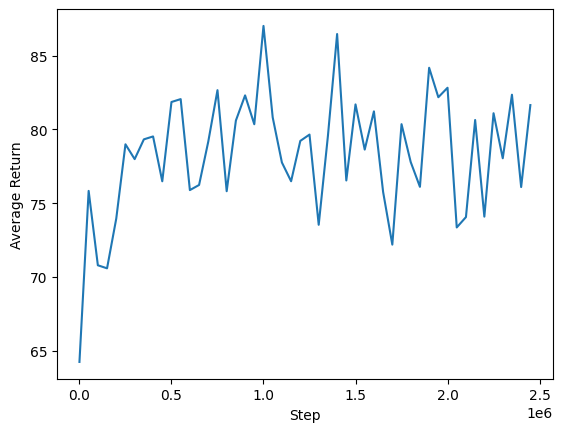

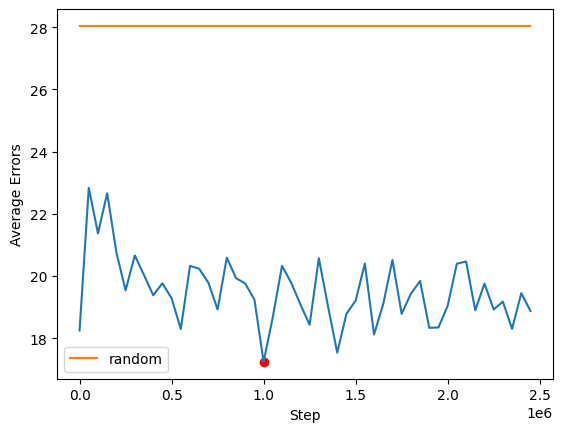

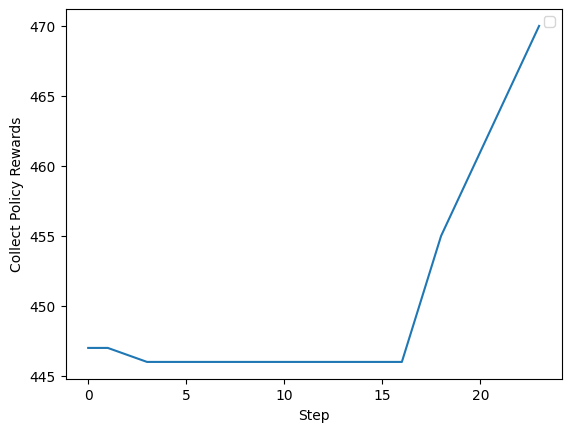

ValueError: setting an array element with a sequence.

In [ ]:
%matplotlib inline
steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(steps, pred_errors)
plt.plot(steps, np.ones(len(pred_errors))*rand_pred_error, label = "random")
plt.scatter([steps[np.argmin(pred_errors)]], [np.min(pred_errors)], c = 'r')
plt.ylabel('Average Errors')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(collect_rewards, np.ones(40)*200/40, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

steps = range(0, eval_interval*len(returns), eval_interval)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'))
plt.ylabel('Collect Policy Rewards')
plt.xlabel('Step')
plt.legend()
plt.show()

In [ ]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

25.352777703762055 14.662134084146382


In [ ]:
# Restore best model
checkpoint_dir = os.path.join(train_log_dir, 'checkpoint')
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

In [ ]:
# Evaluate model again
avg_return, avg_error, all_errors  = compute_avg_return(eval_py_env, agent.policy, n_agents, 500, batched = True)
print(avg_return, avg_error)

25.001144867897032 15.026162973258096


In [ ]:
saved_policy = tf.saved_model.load(train_log_dir)
#saved_policy = tf.saved_model.load("./models/RL/2023-06-09--00:06:51")
avg_return, avg_error, all_errors = compute_avg_return(eval_py_env, saved_policy, n_agents, 500, batched = True)
print(avg_return, avg_error, np.median(all_errors))

25.558206263661386 14.494309077139667 12.826106790826623
